<a href="https://colab.research.google.com/github/Gabriel-boop-deep/Petron/blob/main/Petron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA do zero ao app

## Contexto

Sem dados de treinamento suficientes, seus modelos de aprendizado profundo e aprendizado de máquina não podem aprender os padrões discriminativos subjacentes necessários para fazer classificações robustas.

O que levanta a questão:

Como você reúne imagens suficientes ao treinar modelos de aprendizado profundo?

Algoritmos de aprendizado profundo, especialmente Redes Neurais Convolucionais, podem ser feras famintas por dados.

E para piorar a situação, anotar manualmente um conjunto de dados de imagem pode ser um processo demorado, tedioso e até caro.

Então, existe uma maneira de aproveitar o poder das Imagens do Google para coletar imagens de treinamento rapidamente e, assim, reduzir o tempo necessário para criar seu conjunto de dados?

Pode apostar que existe.

No WS de hoje, demonstrarei como você pode usar o Imagens do Google para coletar dados de treinamento de maneira rápida (e fácil) para seus modelos de aprendizado profundo.

## Preparação

Primeiro, configure seu colab para trabalhar com GPU. GPU, também chamada de 'palca de vídeo' são hardwares de processamento paralelo que funcionam muito melhor com DeepLearning

![](https://media-exp1.licdn.com/dms/image/C5612AQESD6CvV-ja8Q/article-inline_image-shrink_1500_2232/0/1645765520416?e=1667433600&v=beta&t=x5Zjq-HD78L19b3yDFiSatGf0QsqEAjqWdI6-ogR724)

## Dataset

### Scraping

Primeiro, instalamos e importamos um "Web Scraper", dependendo do contexto, também chamado de "crawler"
Para saber mais funções dele no futuro, podes ler a documentação no link: https://icrawler.readthedocs.io/en/latest/builtin.html#search-engine-crawlers

In [2]:
!pip install icrawler       > /dev/null     # dica: ao adicional             > /dev/null     a instalação ocorre de forma silenciosa, sem output.
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
import warnings      # dica: você também pode silenciar avisos ignorando-os
warnings.filterwarnings("ignore")

Indique a palavra a ser pesquisada no google imagens, a quantidade e o local para salva-las e em seguida rode o Crawler

In [3]:
# Define a função que baixa as imagens
def take_images(keyword, max_num_img, server): # Informações
    # Esta biblioteca pode deixar de funcionar caso solicite mais de 1000 imagens
    # Roda o scraper
    local = f'./images/downloaded/{keyword}'
    if server == 'google':
        crawler = GoogleImageCrawler(storage={'root_dir': local})
    if server == 'bing':
        crawler = BingImageCrawler(storage={'root_dir': local})
    crawler.crawl(keyword=keyword, max_num=max_num_img)



# baixa diversas imagens de uma lista de classes
classes = ['Mar com machas de petroleo','Mar sem manchas de petroleo']
for classe in classes:
    take_images(classe, max_num_img=500, server='bing')

ERROR:downloader:Exception caught when downloading file http://www.blogentretenido.com/wp-content/uploads/2015/10/enorme-mancha-en-el-mar-estaba-viva-pensaban-que-era-petroleo-1024x576.jpg, error: HTTPConnectionPool(host='www.blogentretenido.com', port=80): Max retries exceeded with url: /wp-content/uploads/2015/10/enorme-mancha-en-el-mar-estaba-viva-pensaban-que-era-petroleo-1024x576.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd472a97070>: Failed to establish a new connection: [Errno -2] Name or service not known')), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file http://www.blogentretenido.com/wp-content/uploads/2015/10/enorme-mancha-en-el-mar-estaba-viva-pensaban-que-era-petroleo-1024x576.jpg, error: HTTPConnectionPool(host='www.blogentretenido.com', port=80): Max retries exceeded with url: /wp-content/uploads/2015/10/enorme-mancha-en-el-mar-estaba-viva-pensaban-que-era-petroleo-1024x576.jpg (Caused by NewConne

Pronto! Agora temos as imagens salvas ali ao lado esquerdo no explorer. Caso você queira baixar novas imagens? Descomente a celula abaixo. Ela deleta todas as imagens baixadas.

In [4]:
from shutil import rmtree
#rmtree('/content/images')   #deleta tudo no diretório caso você queira recomeçar

### Separação dos dados de Treino e Validação

In [5]:
from random import Random
import shutil
import os

keys = []

os.path.sep = '/'
!cd "/content/"
for root, dirs, files in os.walk("./images/downloaded/"):
    for filename in files:
        keys.append(f"{root}/{filename}")

# Randomizar os inputs. (Vamos eliminar possibilidade de viés por ordem)
seed = 2022
randomizer = Random(seed)
randomizer.shuffle(keys)

input_files = []

for key in keys:
    input_files.append(key)

# Separa 20% dos dados para validação
test_split_size = 0.10
split_idx = int(len(input_files) * test_split_size)

train_input_files = input_files[:-split_idx]
val_input_files = input_files[-split_idx:]

# Criar diretórios para os dados de treino e validação
for file_train in train_input_files:
    train_path = f"./images/train/{file_train.split('/')[-2]}"
    os.makedirs(train_path, exist_ok=True)
    shutil.copy(file_train, f"{train_path}/{file_train.split('/')[-1]}")

for file_valid in val_input_files:
    valid_path = f"./images/valid/{file_valid.split('/')[-2]}"
    os.makedirs(valid_path, exist_ok=True)
    shutil.copy(file_valid, f"{valid_path}/{file_valid.split('/')[-1]}")

print(f'Train input files: {len(train_input_files)}')
print(f'Val input files: {len(val_input_files)}')

Train input files: 310
Val input files: 34


## Deeplearning Model

In [6]:
!pip install fastai > /dev/null

In [7]:
from fastai.vision.all import *
from fastai.vision.augment import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Carregamento das imagens

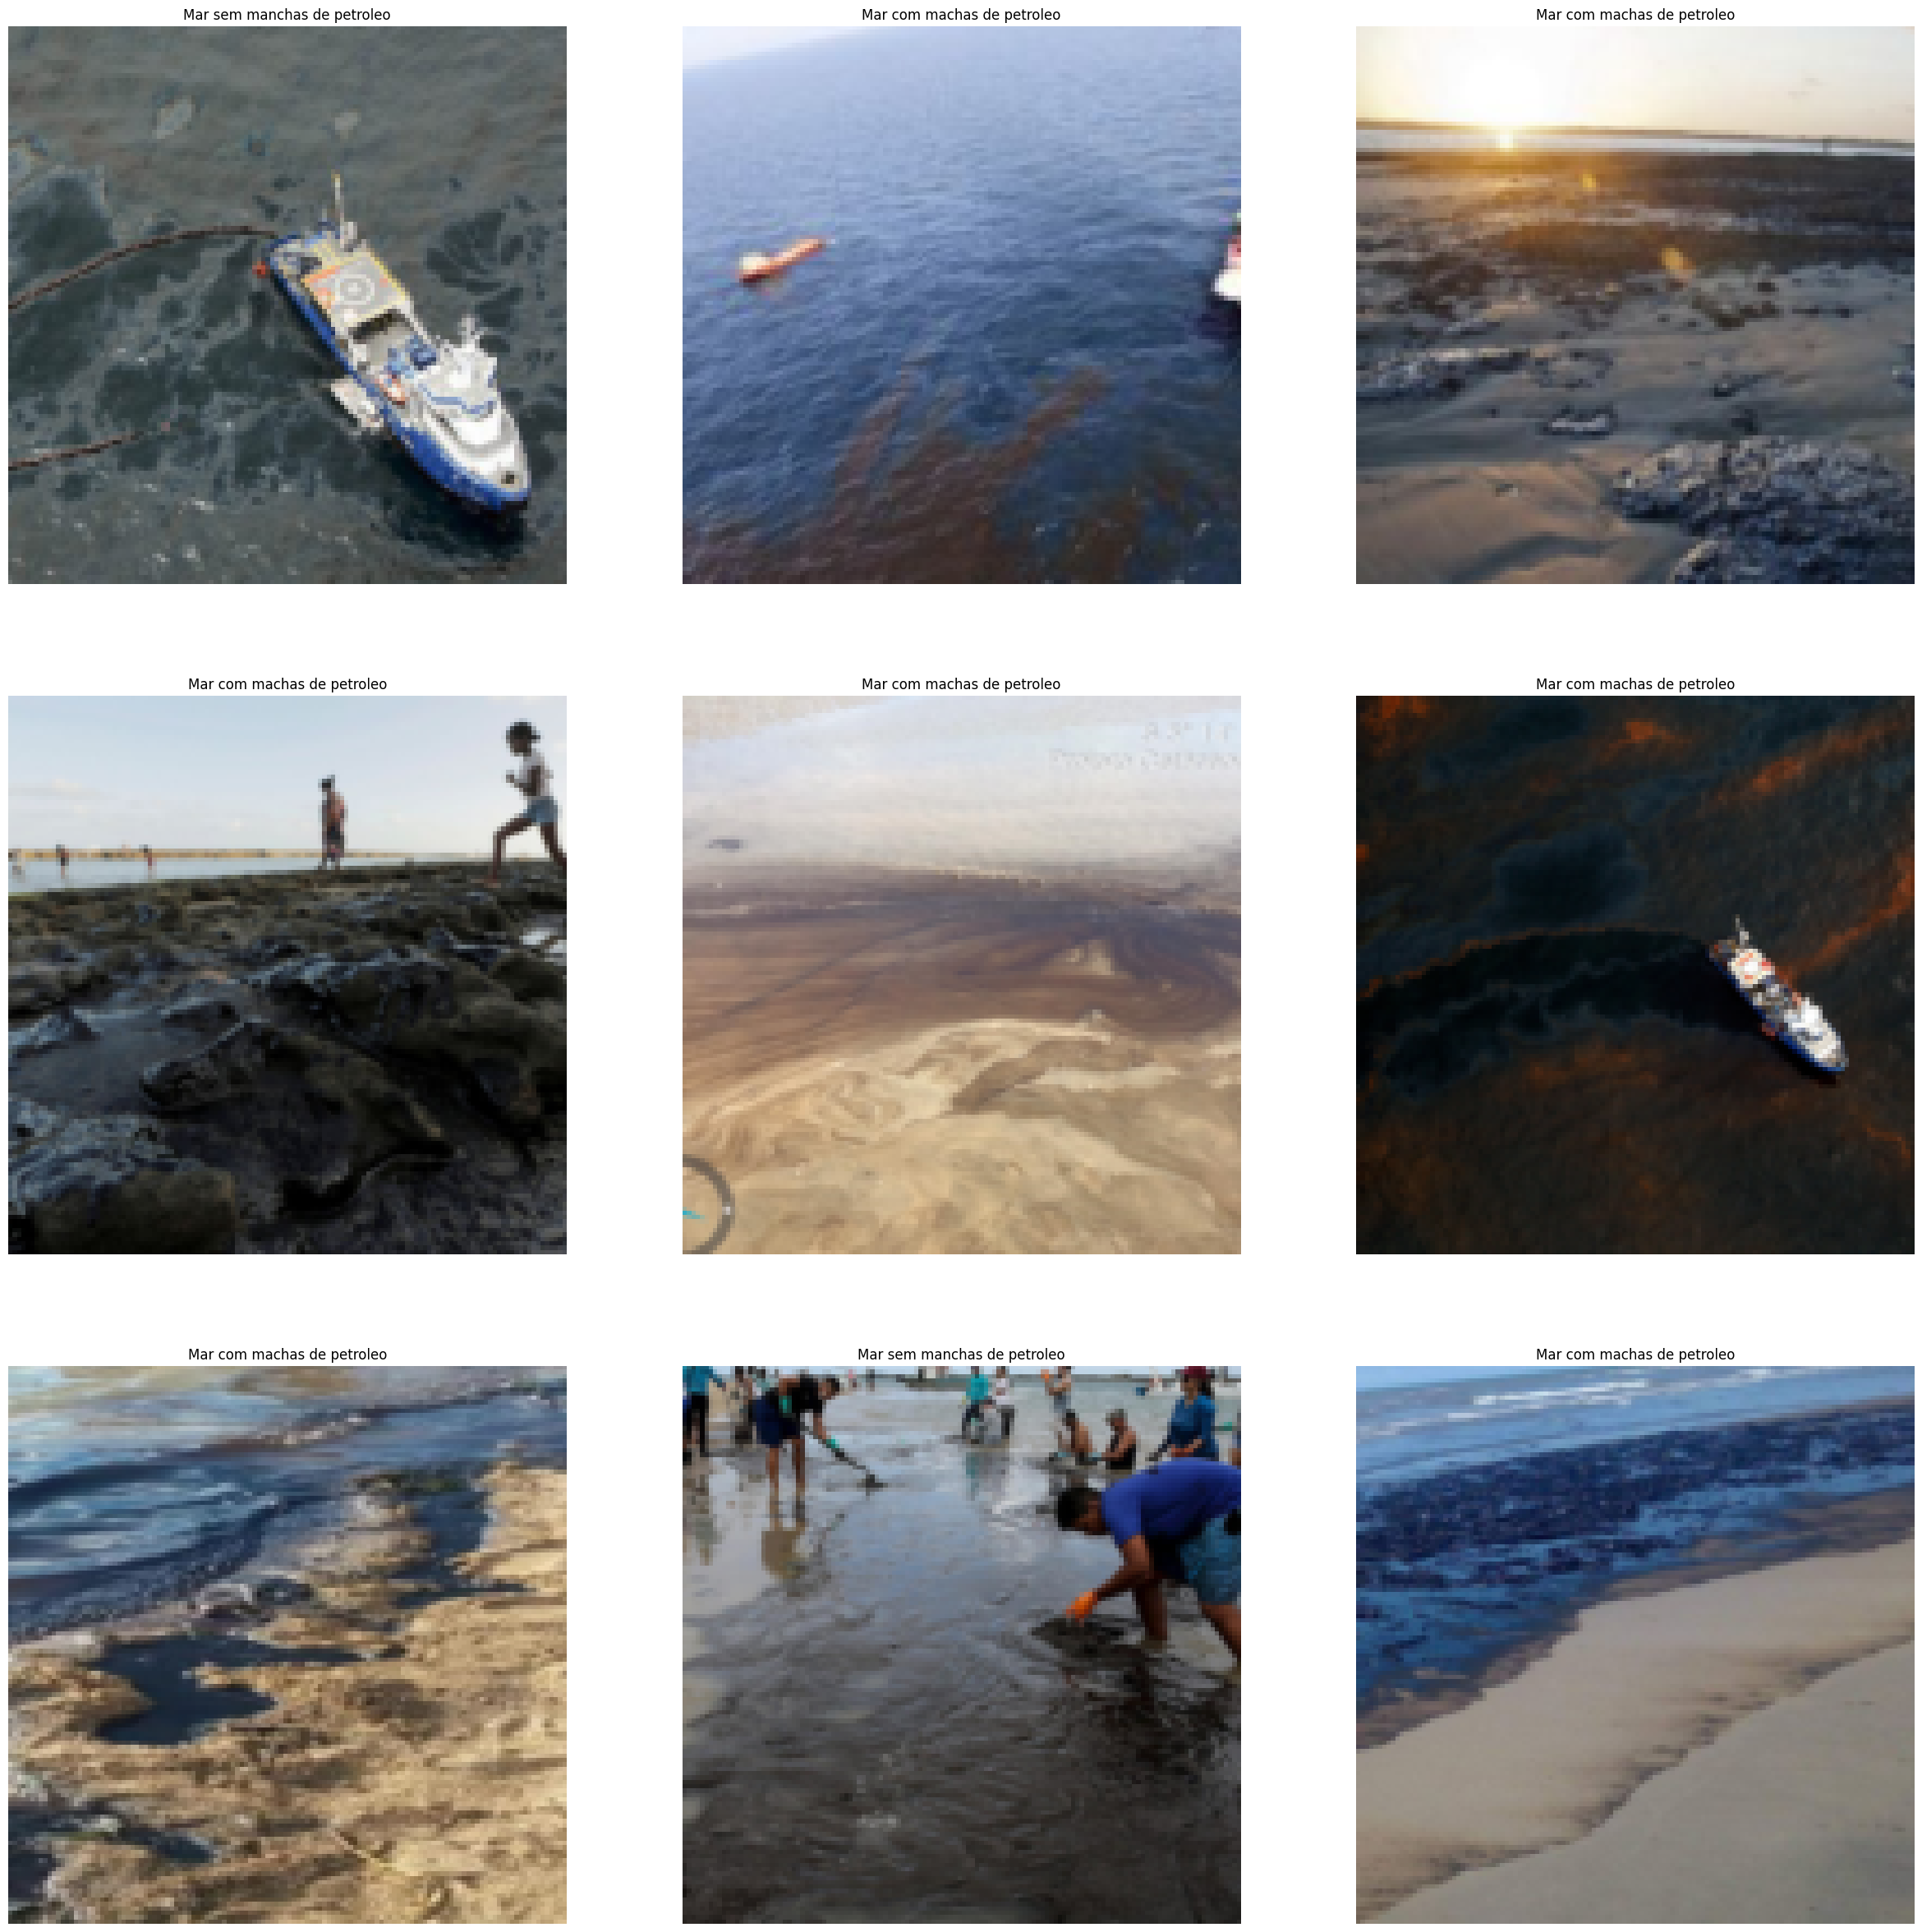

In [10]:
path = Path("./images")

# Carrega as imagens e suas labels e ainda dividindo um grupo de teste com 20%
dataset = ImageDataLoaders.from_folder(path, item_tfms=RandomResizedCrop(128, min_scale=0.35), splitter=RandomSplitter(valid_pct=0.2, seed=42))


# visualisa o dataset
dataset.show_batch(figsize=(30, 30))

### Escolhendo o modelo

### Criando Entrada e saída

### Treinando a IA

In [ ]:
learn = vision_learner(dataset, resnet34, metrics=error_rate)         # testar usar eficientnetv2    e cnn_learner
learn.fine_tune(6)

### aqui dá pra usar fast.ai ou tf

## Avaliação

### Faça uma  predição

In [ ]:
# Veja a curva de Loss 
learn.recorder.plot_loss()

In [ ]:
learn.show_results(max_n=20)

### Matriz de confusão

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### outros

In [ ]:
#Teste em uma imagem inteira

def predict(img):
    img=PILImage.create(img)
    labels = learn.dls.vocab
    pred, pred_idx, probs = learn.predict(img)
    predict_ = {labels[i]: float(probs[i]) for i in range(len(labels))}
    res = {key : round(predict_[key], 4) for key in predict_}   # aqui é só para arredondar
    return print(f'Probabilidade: {res}')

file_test = keys[0]    
predict(file_test)
Image.open(file_test)


def predict(img):
    img=PILImage.create(img)
    pred, pred_idx, probs = learn.predict(img)
    return {classes[i]: float(probs[i]) for i in range(len(classes))}

    



In [ ]:
labels = learn.dls.vocab

def predict(img):
    img=PILImage.create(img)
    pred, pred_idx, probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

predict(file_test)

## Deploy

In [ ]:
# Exportar o modelo
learn.export()

### Gradio

In [ ]:
!pip install -q gradio

In [ ]:
import gradio
from gradio.components import Image, Label
gradio.Interface(fn=predict, inputs=Image(shape=(224,224)), outputs = Label(num_top_classes=2)).launch(share=True)

# Extras

In [ ]:
#coloque sua aplicação na nuvem usando huggingFace + Gradio!!!!!

In [ ]:
# se quiser retirar imagens do duckduckgo
'''
!pip install -q jmd_imagescraper

from pathlib import Path
root = Path().cwd()/"images"

from jmd_imagescraper.core import * # dont't worry, it's designed to work with import *

# a primeira string é o nome da pasta. a Segunta são as keywords
duckduckgo_search(root, "Cats", "cute kittens", max_results=10)
duckduckgo_search(root, "Dogs", "cute puppies", max_results=10)
duckduckgo_search(root, "Birds", "cute baby ducks and chickens", max_results=10)

'''